In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
import pairpro.user_blast as ub

import ray
from joblib import Parallel, delayed
from datasketch import MinHash, MinHashLSH
import nltk

from scipy.optimize import curve_fit
from denseweight import DenseWeight

In [2]:
def compute_protein_kgram(seq, k=3):
    """Find all k-grams in a amino acid sequence.
    
    No spaces are accepted.
    
    Parameters
    ----------
    seq: str
        Protein sequence
    k : int
        Size of grams
        
    Returns
    -------
    list of tuple of str
    """
    if " " in seq:
        raise ValueError(f"Ensure no spaces are in input: {seq}")
    else:
        return nltk.ngrams(seq, k)
        
def compute_min_hash(seq, k=3, num_perm=100):
    """Compute the MinHash of a protein sequence based on kgrams
    
    Parameters
    ----------
    seq: str of protein sequence
    k: size of k grams
    n: number of permutations for minhash
    """
    minhash = MinHash(num_perm=num_perm)
    grams = compute_protein_kgram(seq, k=k)
    for g in grams:
        minhash.update("".join(g).encode('utf-8')) # make explicit the string method encoding? 
    return minhash

def quick_jaccard(s1, s2):
    """
    {HA updated} Calculates the Jaccard similarity between sequence 1 (set) and sequence 2 (set) pairs based on minhashing

    Jaccard similarity is defined as the size of the intersection divided by the size of the union of two sets.

    Parameters
    ----------
    s1: protein sequence
    s2: protein sequence
    """
    # intersection = len(s1.intersection(s2))
    # union = len(s1.union(s2))
    # jaccard_similarity = intersection / union if union > 0 else 0
    # return jaccard_similarity
    return s1.jaccard(s2)

def weighted_filter(x, weight, cutoff):
    """
    TODO
    """
    new_x = []
    norm = max(weight(x))
    for i, val in enumerate(x):
        if val > cutoff:
            if np.random.rand() < (weight(val)/norm):
                new_x.append(i)
    return new_x


def parallel_jaccard(row):
    """
    New func
    """
    return quick_jaccard(compute_min_hash(row['subject']), compute_min_hash(row['query']))
    

def bad_sampler(df, size, cpus, weight=None, cutoff=0.1):
    """
    TODO
    {HA: change frac= 1 to 0.1}
    """
    bad_sample = pd.DataFrame(columns=['query','subject','jaccard'])

    while bad_sample.shape[0] < size:
        query_sample = bad_sample.sample(frac=0.1)['query']
        subj_sample = bad_sample.sample(frac=0.1)['subject']
        bad_pairs = pd.DataFrame([query_sample.reset_index(drop=True), subj_sample.reset_index(drop=True)]).T

        # need to add drop real pairs step
        # need to catalog used index pairs
        if weight is not None:
            # parrallel compute
            bad_pairs['jaccard'] = Parallel(n_jobs=cpus)(delayed(parallel_jaccard)(row) for row in bad_pairs.iterrows())

            filtered_idx = weighted_filter(bad_pairs['jaccard'], weight, cutoff)
            filtered_bad_pairs = bad_pairs.iloc[filtered_idx]
        else:
            filtered_bad_pairs = bad_pairs

        print(f"Added {len(filtered_bad_pairs)} bad pairs")
        bad_sample = pd.concat([bad_sample, filtered_bad_pairs], ignore_index=True)
    return bad_sample

### HA Playground

In [3]:
start = timer()
data = pd.read_csv('../OMA_seq_1m_limit.csv')
end = timer()
print(f'Time to do the compute: {end-start} s')

Time to do the compute: 4.33696835511364 s


Let's explore the dataframe

In [4]:
data.head()

Unnamed: 0 protein1_uniprot_id protein2_uniprot_id  \
0           0              A4YFY4              H8KYH7   
1           1          A0A088E5P1              Q97VT5   
2           2              A4YFY9          A0A3B0PDD1   
3           3              A4YFZ1                 NaN   
4           4              A4YFZ2              Q96XD5   

                                        protein1_seq  \
0  MAKTTAELLMDAISSQVEDVFGIPGTHGLSLYEEIRKRVERQEVRY...   
1  MELRSDLRIKAERGRVEELLSSPSRFAECLPGIQEYEVKGDEFRAV...   
2  MSVELRQVSKRYGKVQAVKGVNLKVEKGEFFVLLGTSGSGKTTILR...   
3  MDKDESGLAKDAIGLWGLVFYSISVILPGGAFAITGAAAIIYGGYS...   
4  MVKVTKKYQVTIPEDVRKKIGLKPFEEVEVVALNDNEILVRRKLRT...   

                                        protein2_seq  
0  MSDNNKAPACGAELVVRNLEAHGVRWVFGIPGAKVDRVFDSLEDSS...  
1  MEFKGTFDVKRTIEAVKGFLINPKQFAECLTGLQSYETNNNVFKAI...  
2  MDNKNSVIKFENVSFSYNSKKQVLKNVSYEIYEKEYVCIVGHNGSG...  
3  MAITKGETPQLQAGALGLFSIVAAVIATNGPLTALIGAVPVAMAMG...  
4  MVKLTRKFQITIPKEVREKINLKPNEKFEVIVLNDNEILLRRKVKN...

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   Unnamed: 0           1000000 non-null  int64 
 1   protein1_uniprot_id  997931 non-null   object
 2   protein2_uniprot_id  935635 non-null   object
 3   protein1_seq         1000000 non-null  object
 4   protein2_seq         1000000 non-null  object
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


Let's drop the unneeded columns!

In [6]:
data.drop(columns=['Unnamed: 0', 'protein1_uniprot_id', 'protein2_uniprot_id'], inplace=True)
# show df
data.head()

protein1_seq  \
0  MAKTTAELLMDAISSQVEDVFGIPGTHGLSLYEEIRKRVERQEVRY...   
1  MELRSDLRIKAERGRVEELLSSPSRFAECLPGIQEYEVKGDEFRAV...   
2  MSVELRQVSKRYGKVQAVKGVNLKVEKGEFFVLLGTSGSGKTTILR...   
3  MDKDESGLAKDAIGLWGLVFYSISVILPGGAFAITGAAAIIYGGYS...   
4  MVKVTKKYQVTIPEDVRKKIGLKPFEEVEVVALNDNEILVRRKLRT...   

                                        protein2_seq  
0  MSDNNKAPACGAELVVRNLEAHGVRWVFGIPGAKVDRVFDSLEDSS...  
1  MEFKGTFDVKRTIEAVKGFLINPKQFAECLTGLQSYETNNNVFKAI...  
2  MDNKNSVIKFENVSFSYNSKKQVLKNVSYEIYEKEYVCIVGHNGSG...  
3  MAITKGETPQLQAGALGLFSIVAAVIATNGPLTALIGAVPVAMAMG...  
4  MVKLTRKFQITIPKEVREKINLKPNEKFEVIVLNDNEILLRRKVKN...

#### Quick distribution check

In [7]:
jac_list = []
sample = data.sample(2000).reset_index(drop=True)
start = timer()
for row in sample.iterrows():
    jac_list.append(quick_jaccard(compute_min_hash(row[1]['protein1_seq']), compute_min_hash(row[1]['protein2_seq'])))
end = timer()
print(f'Time to do the compute: {end-start} s')

Time to do the compute: 13.853414476849139 s


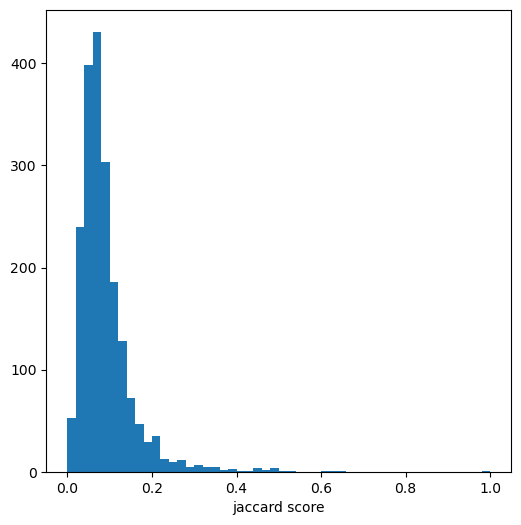

In [8]:
# plotting
fig, ax = plt.subplots(figsize=(6,6))
plt.hist(jac_list, bins=50)
ax.set_xlabel('jaccard score')
plt.show()

In [9]:
sample

protein1_seq  \
0     MEKIEYATATGALSTVWLLIALPLASAAILFLLGRRADKWGHWLGV...   
1     MAIDPSGILLTDRVAVVTGGGAGIGLGIAAGLAAFGARVAIWERDA...   
2     MIASVRGEVLDIALDHVVIEAAGVGYKVMATPATLATLRRGSEARL...   
3     MTAVTSDGTPQAAKVRVRFCPSPTGVPHVGMVRTALFNWAYARHTG...   
4     MTVSSSPAPGPFRNATKPSQRRLSPDLARGFMLLLIAMAYAPMHLE...   
...                                                 ...   
1995  MSDYWLNVALVFALILVNGLLAGSEAAFISLREGQLRELEHRGGRR...   
1996  MSKYVNQEVLVDTKYVLDNVGNEKVRIVEVDYDHSTAYDAWHIPNA...   
1997  MQTLPPLAGITVVTLEQAVSAPMCTRVLADFGARVIKIENPKGGDF...   
1998  MTTKEETTDAYADARDTTEGKVFTVTGGDWDSVIGGHDPVSDERLV...   
1999  MMSNDLLVTDIEAEARTEENIWHSDNSALAAPPAATTSASQDQLPD...   

                                           protein2_seq  
0     MNLLYLTILLPLLGFLLLAFSRGRWSENTAATVGVGSIGLTALVTL...  
1     MANLVNKTALVTGGGTGIGRAIAKRMAKDGANVVIIGRNEATLEES...  
2     MIGRLNGILVEKQPPEILLEVSGVGYEVQMPMTCFYDLPKVGESAI...  
3     MIVTRFAPSPTGYLHIGGLRTALFSYLWARKNGGKFLLRIEDTDKA...  
4     MSSLQPTLTNERIGVLDVLRGMAIFGILFVNLAHFSYPDMYLSMLG...  
...                                                 ...  
1995  MNADPESQSLLAQILILIVLTLINAFLAAAEISVVSINKNRVEQKA...  
1996  MFSNTLVSTEDLAAHLDDPNWVVLDCRFTLTDPGAGREAYEKAHVP...  
1997  MSQTLPLAGIRVVDYSHFLAGPYVGRCLAALGAEVIKVERPGSGDA...  
1998  MSTSHATPRETTEGTVYTVTGGDWDEIAAAAARTDDERIVVNMGPQ...  
1999  MSVRYPLLNRELGILGFNERVLAQAADPQVPLLERLRFICITSSNL...  

[2000 rows x 2 columns]

In [10]:
print(f"The samlpe's type is: {type(sample)}")

The samlpe's type is: <class 'pandas.core.frame.DataFrame'>


Okay. This looks right. So the dataframe works.

### Follow Ryan's stuff (BLAST stuff)

In [13]:
# ray.init(address='ray://127.0.0.1:8005', runtime_env={'working_dir': '/gscratch/cheme/users/halanzi/git_repos/PairProphet/pairpro'}, num_cpus=4, ignore_reinit_error=True)

2023-10-30 14:00:37,622	INFO client_builder.py:252 -- Passing the following kwargs to ray.init() on the server: num_cpus, ignore_reinit_error


ConnectionError: ray client connection timeout

In [14]:
out, con = ub.make_blast_df(sample, cpus=4, path = 'blast_db.db')
start = timer()
out['jaccard'] = [quick_jaccard(compute_min_hash(row[1]['subject']), compute_min_hash(row[1]['query'])) for row in out.iterrows()]
end = timer()
print(f'Time to do the compute: {end-start} s')

Found and skipped 9 row(s) containing
        invalid amino acid codes.
Time to do the compute: 19.44243673607707 s


In [12]:
test = bad_sampler(out, 100, 4, dw, cutoff = 0)

NameError: name 'dw' is not defined

In [15]:
con.close()

Weirdly, connection doesn't actually close.

---

### Old exploratory code by RF

In [31]:
df = pd.read_csv('/mnt/s/OMA/OMA_seq_1m_limit.csv')
df.drop(columns=['Unnamed: 0', 'protein1_uniprot_id', 'protein2_uniprot_id'], inplace=True)

In [198]:
jac = []
sample = df.sample(2000).reset_index(drop=True)
for row in sample.iterrows():
    jac.append(quick_jaccard(compute_min_hash(row[1]['protein1_seq']), compute_min_hash(row[1]['protein2_seq'])))

/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-pa

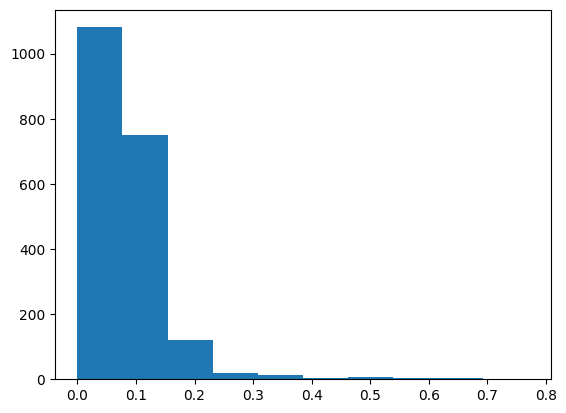

In [199]:
# Range of jaccard scores for random sample of OMA
plt.hist(jac, bins=10);

Found and skipped 1 row(s) containing
        invalid amino acid codes.
Found and skipped 1 row(s) containing
        invalid amino acid codes.
Found and skipped 1 row(s) containing
        invalid amino acid codes.
Found and skipped 1 row(s) containing
        invalid amino acid codes.
Found and skipped 1 row(s) containing
        invalid amino acid codes.
Found and skipped 1 row(s) containing
        invalid amino acid codes.


/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-pa

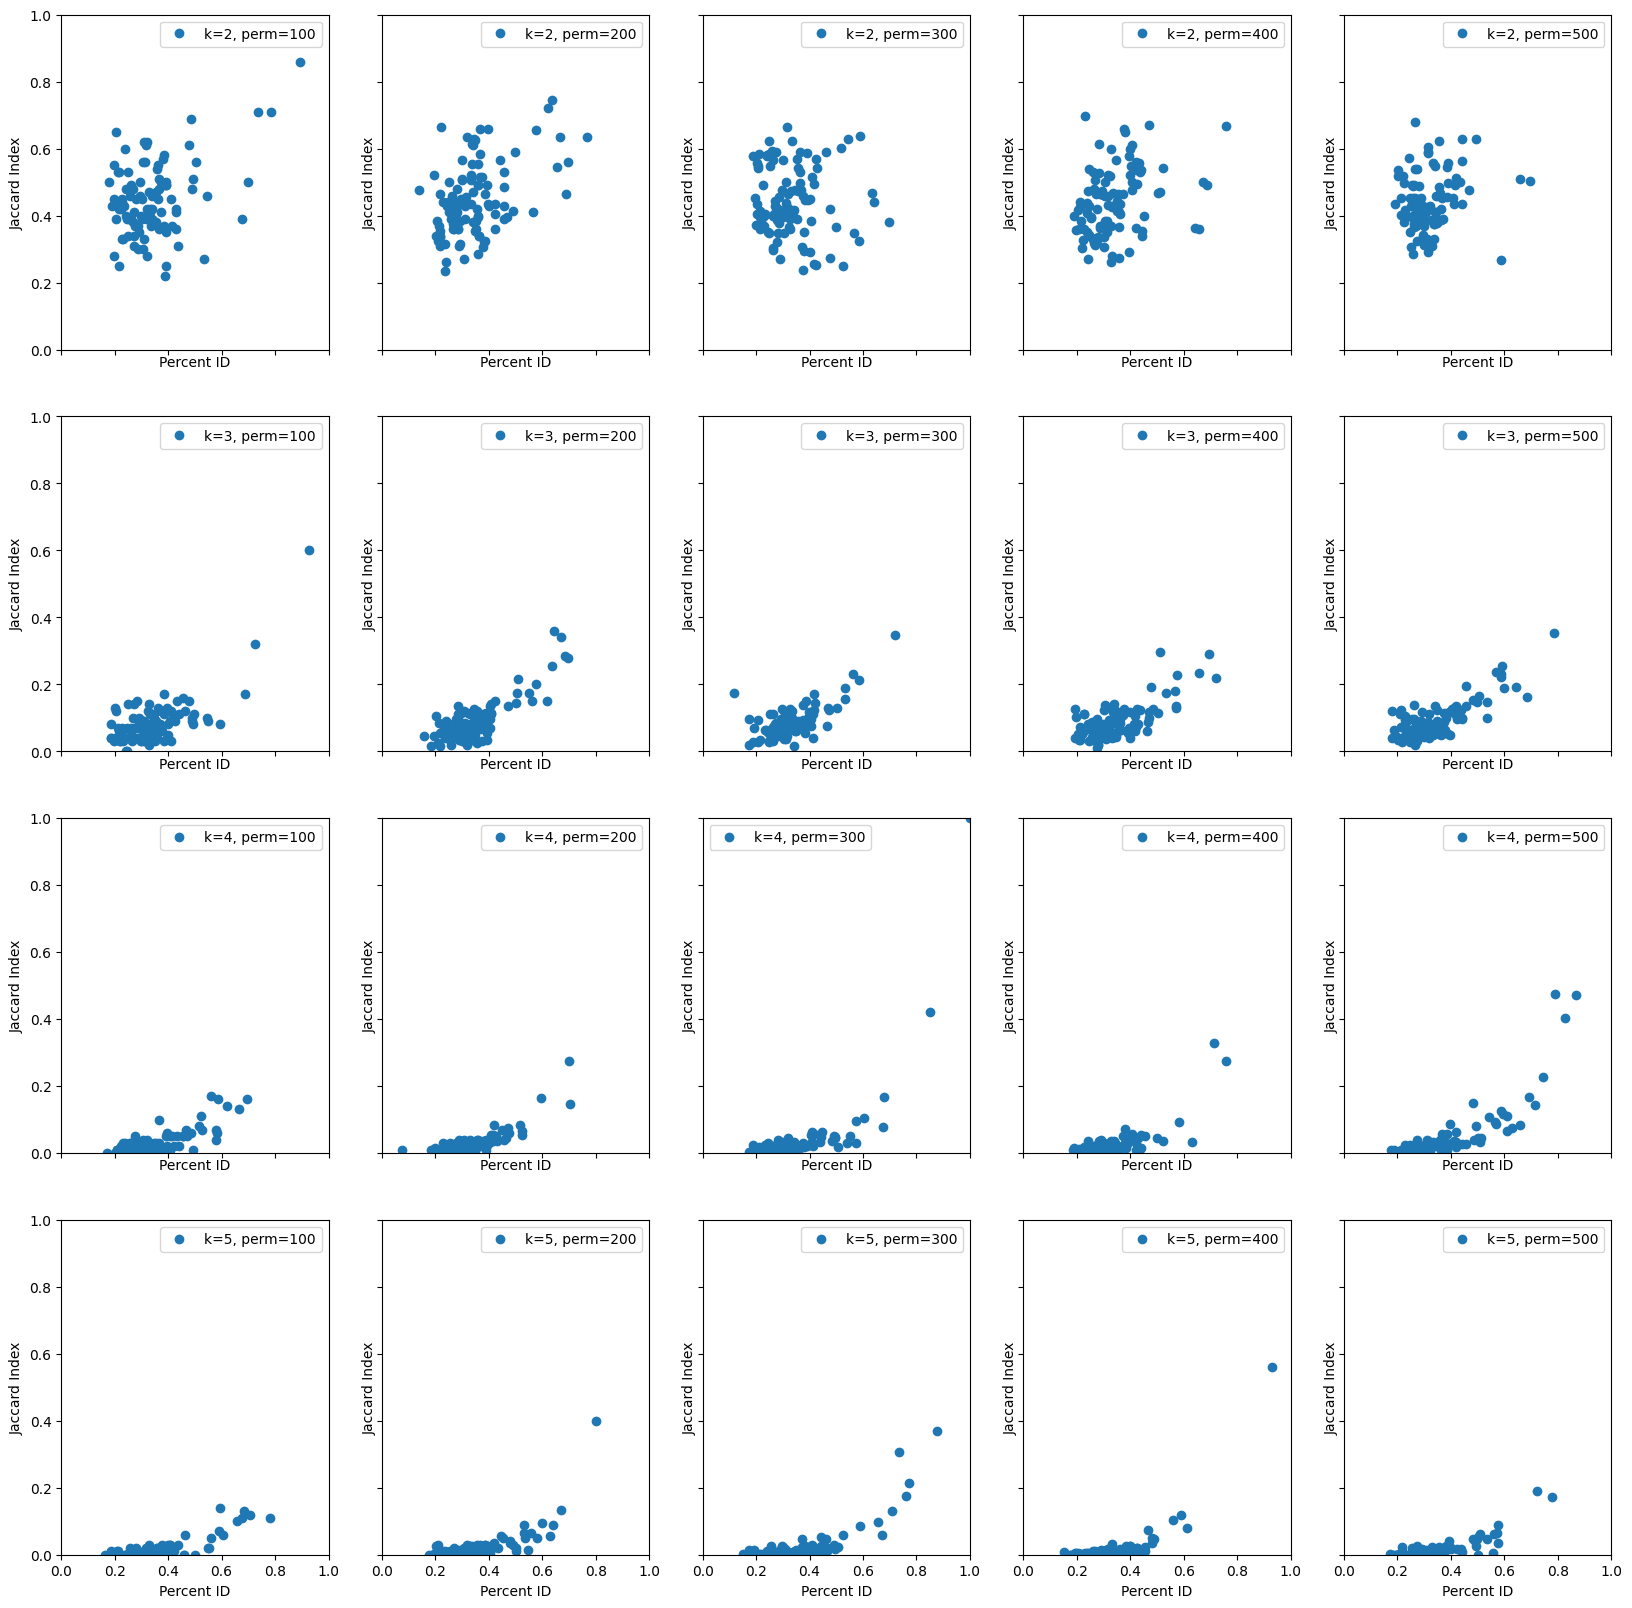

In [230]:
kmers = [2,3,4,5]
perms = [100, 200, 300, 400, 500]

def k_perm_crossplot(kmers, perms, df):
    fig, ax = plt.subplots(len(kmers), len(perms), figsize=(20,20), sharex=True, sharey=True)
    ax[0,0].set_xlim(0,1)
    ax[0,0].set_ylim(0,1)
    for i, k in enumerate(kmers):

        for j, perm in enumerate(perms):

            out, _ = ub.make_blast_df(df, path = 'test_db.db')

            jac = []
            for row in out.iterrows():
                jac.append(quick_jaccard(compute_min_hash(row[1]['subject'], k=k, num_perm=perm), compute_min_hash(row[1]['query'], k=k, num_perm=perm)))


            ax[i,j].plot(out['local_gap_compressed_percent_id'], jac, 'o', label=f"k={k}, perm={perm}")
            ax[i,j].set_xlabel('Percent ID')
            ax[i,j].set_ylabel('Jaccard Index')
            ax[i,j].legend()


In [200]:
out, _ = ub.make_blast_df(sample, path = 'blast_db.db')
out['jaccard'] = [quick_jaccard(compute_min_hash(row[1]['subject']), compute_min_hash(row[1]['query'])) for row in out.iterrows()]

Found and skipped 3 row(s) containing
        invalid amino acid codes.


/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-pa

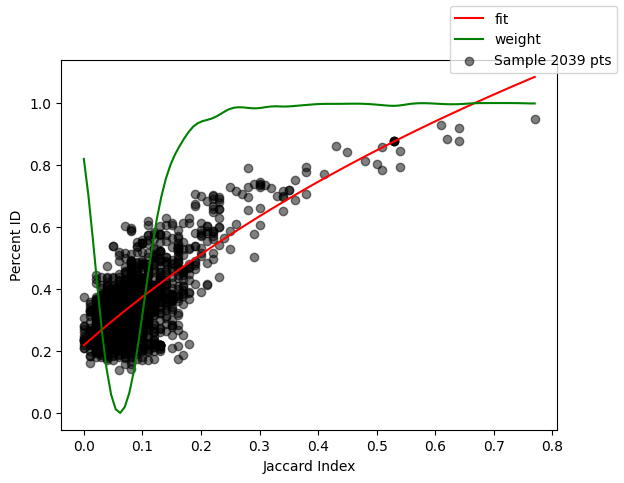

In [218]:
def func(x, a, b, c):
    return a + b*np.log(x+c)

fig, ax = plt.subplots()
y = out['local_gap_compressed_percent_id']
x = list(out['jaccard'])
ax.scatter(x, y, label=f'Sample {len(x)} pts', color = 'k', alpha=0.5)
ax.set_ylabel('Percent ID')
ax.set_xlabel('Jaccard Index')


xfit = np.linspace(0, max(x), 100)
dw = DenseWeight(alpha=1)
weights = dw.fit(x)
popt, pcov = curve_fit(func, x, y, sigma=1/weights, maxfev=10000)

ax.plot(xfit, func(xfit, *popt), label='fit', color = 'r')
ax.plot(xfit, dw(xfit)/max(dw(xfit)), color = 'g', label='weight')
fig.legend()

In [195]:
test = bad_sampler(out, 100, dw, cutoff = 0)

Added 1911 bad pairs


In [196]:
test_aligned, _ = ub.make_blast_df(test, path='test.db')
test_aligned['jaccard'] = test['jaccard']

In [161]:
bad_pairs = pd.DataFrame([out.sample(1000).reset_index(drop=True)['query'], out.sample(1000).reset_index(drop=True)['subject']]).T

In [163]:
outbad, _ = ub.make_blast_df(bad_pairs, path = 'blast_db.db')

In [164]:
outbad['jaccard'] = [quick_jaccard(compute_min_hash(row[1]['subject']), compute_min_hash(row[1]['query'])) for row in outbad.iterrows()]

/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-pa

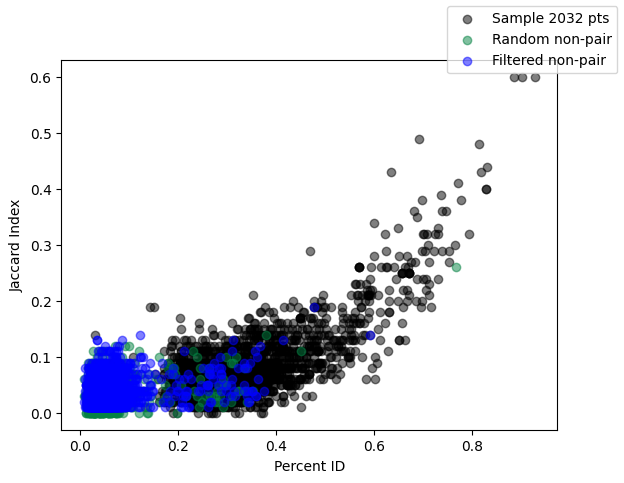

In [197]:
fig, ax = plt.subplots()

ax.scatter(out['local_gap_compressed_percent_id'], out['jaccard'], label=f'Sample {len(x)} pts', color = 'k', alpha=0.5)
ax.scatter(outbad['local_gap_compressed_percent_id'], outbad['jaccard'], label=f'Random non-pair', color = '#048243', alpha=0.5)
ax.scatter(test_aligned['local_gap_compressed_percent_id'], test_aligned['jaccard'], label=f'Filtered non-pair', color = 'blue', alpha=0.5)
ax.set_xlabel('Percent ID')
ax.set_ylabel('Jaccard Index')

x = list(out['local_gap_compressed_percent_id'])
y = out['jaccard']
xfit = np.linspace(0, 1, 100)
dw = DenseWeight(alpha=1)
weights = dw.fit(x)
popt, pcov = curve_fit(func, x, y, sigma=1/weights, maxfev=10000)

#ax.plot(xfit, func(xfit, *popt), '-', label='fit', color = 'r')

fig.legend()

In [169]:
query_sample = out.sample(frac=1)['query']
subj_sample = out.sample(frac=1)['subject']
matching_elements = [elem1 for elem1, elem2 in zip(query_sample, subj_sample) if elem1 == elem2]


In [233]:
test_aligned[test_aligned['local_gap_compressed_percent_id'] >= 0.2].shape[0]/test_aligned.shape[0]

0.03872318158032444

In [234]:
outbad[test_aligned['local_gap_compressed_percent_id'] >= 0.2].shape[0]/outbad.shape[0]

/tmp/ipykernel_8414/1407301653.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outbad[test_aligned['local_gap_compressed_percent_id'] >= 0.2].shape[0]/outbad.shape[0]


0.039

In [236]:
pairs = df.sample(10000).reset_index(drop=True)
scratch = df.sample(250000).reset_index(drop=True)

In [241]:
out, _ = ub.make_blast_df(pairs, path = 'test_db.db')

Found and skipped 19 row(s) containing
        invalid amino acid codes.


KeyboardInterrupt: 

In [286]:
import ray

/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [299]:
test = pd.read_csv('/mnt/s/OMA/230830-truefalse_10k.csv')
ray.init(runtime_env={'working_dir': '/home/ryfran/PairProphet/pairpro'}, ignore_reinit_error=True)
@ray.remote
def jaccard_minhash(query, subject):
    m1 = compute_min_hash(query)
    m2 = compute_min_hash(subject)
    return m1.jaccard(m2)

for i, row in test.iterrows():
    test.iloc[i]['jaccard'] = ray.get(jaccard_minhash.remote(row['query'], row['subject']))

sns.scatterplot(data=test, x='local_gap_compressed_percent_id', y='jaccard', hue='Pair', alpha = 0.5);

2023-08-30 16:29:56,631	INFO worker.py:1474 -- Calling ray.init() again after it has already been called.


/tmp/ipykernel_8414/3805167495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.iloc[i]['jaccard'] = ray.get(jaccard_minhash.remote(row['query'], row['subject']))
/tmp/ipykernel_8414/3805167495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.iloc[i]['jaccard'] = ray.get(jaccard_minhash.remote(row['query'], row['subject']))
/tmp/ipykernel_8414/3805167495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.iloc[i]['

ValueError: Could not interpret value `jaccard` for parameter `y`

In [300]:
test.shape

(10682, 15)

In [301]:
test


Unnamed: 0                                              query  \
0               0  MGSQARRSGSNGFAAASKLDQQRIKEIAVESELTGAASGAPARGTA...   
1               1  MSSPEADPIGPEVLQQWRKLTEEVREHQFRYYVRDAPIISDAEFDA...   
2               2  MDVVIGQLATGLSLGSILLLAALGLSLTFGQMGVINMAHGEFIMAG...   
3               3  MPVRRRAGPIEVGLPEWIYLPAAVGALFVLTPLAAILLRIDWPDFV...   
4               4  MDCISLTNVVKRFGLTYALNGLSFSIPCGGRYSLLGPNGAGKSTTM...   
...           ...                                                ...   
10677       10677  MTLSGKTALVTGAGRGIGRAIARRLARDGAAVIVNYASSAEQAASL...   
10678       10678  MILDRFRLDDRVAVVTGAGRGLGAAIALAFAEVGADVLIAARTQAQ...   
10679       10679  MAGPKRGGTKLRRKEKKNVAAGHAHIKSTFNNTIVSITDPAGAVIS...   
10680       10680  MSGHSKWATTKHKKAVIDARRGKNFAKLIKNIEVAARTGGGDPGGN...   
10681       10681  MKTAVVTGGGSGIGLAIVQRLQADGLHVATIDLKPGDGEFAHAADV...   

                                                 subject  query_id  \
0      MEKGTWVVKKGFAEMFKNGVIMDVTTAEQAKIAEEAGAVAVMALER...        54   
1      MEENKQTLLEEVLQLSSRLREYQKAYYVDNHPLVSDLEYDRFFDRL...       163   
2      MDVAINLLVNGLATGTLIFLLASGLTLIFGLMSVLNFAHGGLFAWG...        38   
3      MFAVSSRRVLPGFTLSLGTSLLFVCLILLLPLSALVMQLSEMSWAQ...       107   
4      MLLELNAVTLAYDTPRGRRTIVDRLSLALERGAIGCLLGASGCGKT...        31   
...                                                  ...       ...   
10677  MTKVLSGKTALVTGGSRGIGAAIARELAEQGADVAISYVASADRAH...       264   
10678  MILDRFRIAGQVAVVTGAGRGLGRAIAVAFAEAGADVLIAARTKQQ...        91   
10679  MAKRKIVKKKVVKKNIAKGIVYISATFNNTMVTVTDEMGNAIAWSS...        10   
10680  MTWQQGKYAATGEEETREIRMSGHSKWATTKHKKAAIDAKRAKAFA...       213   
10681  MIMSEVYPLQDRIALVTGASSGLGRHFGLLLAANGAHVALAARSID...       120   

       subject_id  pair_id  local_gap_compressed_percent_id  \
0              98        0                         0.075342   
1              94        1                         0.067626   
2              91        2                         0.080139   
3             116        3                         0.085185   
4             232        4                         0.054852   
...           ...      ...                              ...   
10677         887      947                         0.299595   
10678         309      504                         0.695817   
10679          68      401                         0.213740   
10680         951      667                         0.261905   
10681         272      230                         0.290598   

       scaled_local_query_percent_id  scaled_local_symmetric_percent_id  \
0                           0.066066                           0.066066   
1                           0.066478                           0.066478   
2                           0.078231                           0.078231   
3                           0.083032                           0.083032   
4                           0.050781                           0.050781   
...                              ...                                ...   
10677                       0.298387                           0.298387   
10678                       0.695817                           0.695817   
10679                       0.212121                           0.212121   
10680                       0.242647                           0.242647   
10681                       0.265625                           0.265625   

       query_align_len  query_align_cov  subject_align_len  subject_align_cov  \
0                333.0         1.000000              333.0           0.873874   
1                707.0         0.981612              707.0           1.000000   
2                294.0         1.000000              294.0           0.972789   
3                277.0         0.971119              277.0           1.000000   
4                256.0         0.921875              256.0           1.000000   
...                ...              ...                ...                ...   
10677            248.0         0.991935              248.0           1.00000

/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryfran/miniconda3/envs/pairpro/lib/python3.11/site-pa

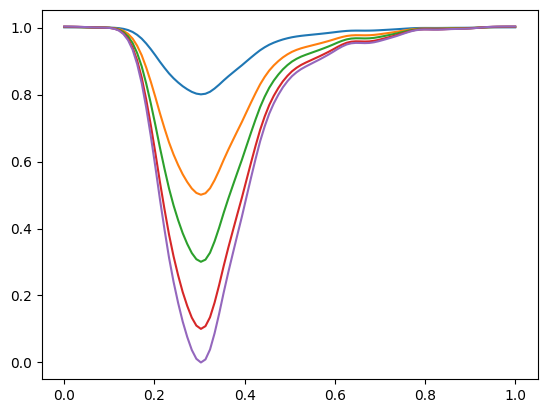

In [272]:
x = np.linspace(0, 1, 100)

for a in [0.2, 0.5, 0.7, 0.9, 1]:
    dw = DenseWeight(alpha=a)
    weights = dw.fit(list(tr['local_gap_compressed_percent_id']))
    norm = np.max(weights)
    plt.plot(x, dw(x)/norm)

In [277]:
dw

In [279]:
np.where(weights == min(weights))

(array([599, 796]),)

In [281]:
tr.iloc[796]['local_gap_compressed_percent_id']

0.3037037037037037

In [282]:
min(weights)

3.1575028128568525e-06